# Optimization notebook
This notebook is to run a multi-objective optimization with the Zambezi model. Two alternatives will be given to that end. First implementation is with the Platypus library which has a fairly simple interface. The second implementation is the EMA Workbench which additionally offers parallelization functionality

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../src')
from model_zambezi_OPT import model_zambezi

from platypus import NSGAII, Problem, Real

In [2]:
ZambeziProblem = model_zambezi()

## Platypus (NSGAII)

In [3]:
problem = Problem(ZambeziProblem.Nvar, ZambeziProblem.Nobj)
problem.types[:] = Real(0, 1)
problem.function = ZambeziProblem.evaluate

algorithm = NSGAII(problem=problem, population_size=20)
algorithm.run(100)

In [4]:
objectives_outcome = dict()
for i, column_name in enumerate(['Hydropower','Environment','Irrigation']):
    objectives_outcome[column_name] = [s.objectives[i] for s in algorithm.result]

objectives_df = pd.DataFrame(objectives_outcome)


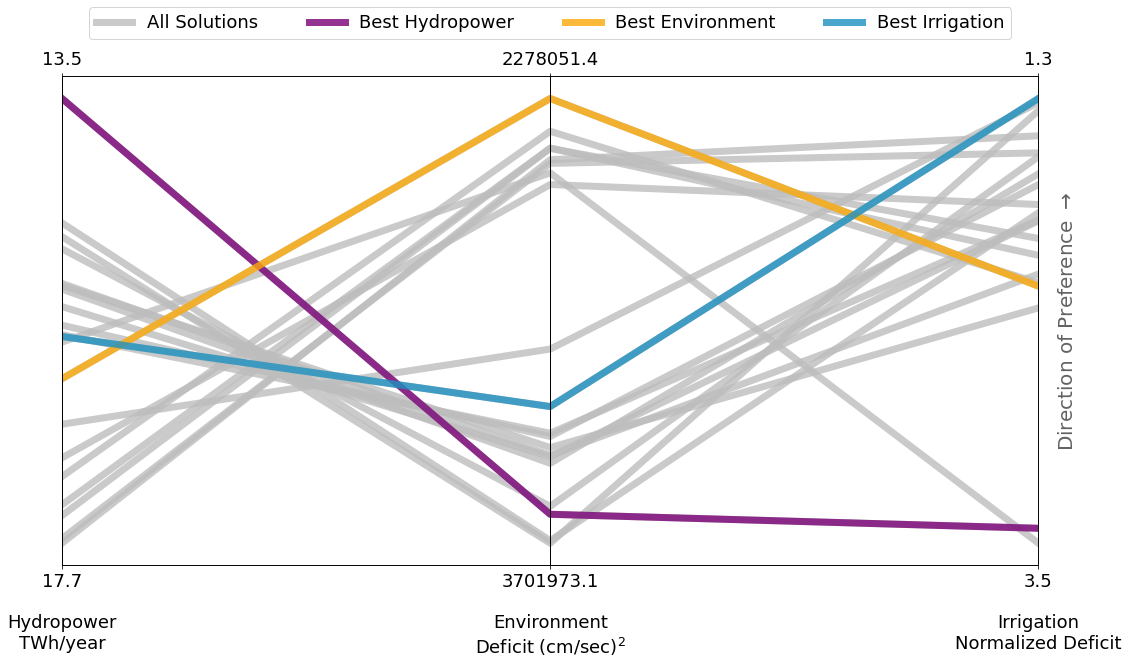

In [5]:
from various_plots import parallel_plots
parallel_plots(objectives_df)

## EMA Workbench

In [48]:
def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation


In [56]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model)

model = Model('zambeziproblem', function=model_wrapper)

model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

#specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]

In [61]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, IpyparallelEvaluator, ema_logging
from ema_workbench.em_framework.ema_ipyparallel import (start_logwatcher, set_engine_logger,
                                  initialize_engines, cleanup, _run_experiment)
from ipyparallel import Client

rc = Client()

ema_logging.log_to_stderr(ema_logging.INFO)

with IpyparallelEvaluator(model, client=rc) as evaluator:
    results = evaluator.optimize(nfe=100, searchover='levers',
    epsilons=[0.1,]*len(model.outcomes))

NameError: name 'set_engine_logger' is not defined